# Dog-Breed Classifier

## Introduction 

In this notebook, we are going to develop an algorithm that could be used as part of a mobile or web app. At the end of this project, our code will accept any user-supplied image as input: If a dog is detected in the image, it will provide an estimate of the dog's breed; if a human is detected, it will provide an estimate of the dog's breed that is most resembling.

The image below displays potential sample output of the finished project.

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed. There are many points of possible failure, and no perfect algorithm exists. Our imperfect solution will nonetheless create a fun user experience!

## The Road Ahead

We break the notebook into separate steps:

* [Step 0](#step0): Import Packages and Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write our Algorithm
* [Step 6](#step6): Test our Algorithm

Feel free to use the links below to navigate the notebook!

<a id='step0'></a>
## Step 0: Import Packages and Datasets

First, we have to make sure that we have downloaded the needed packages (see it below) and the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). Unzip the folder and place it in this project's home directory, at the location `/dog_images`.

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip). Unzip the folder and place it in the home directory, at location `/lfw`.

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the two code cells below, we import the needed packages and save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# Needed packages imports:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2, os, torch, time
from torch import nn, optim
from torchvision import datasets, models, transforms
from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Load filenames for human and dog images:
human_files = np.array(glob('/data/lfw/*/*'))
dog_files = np.array(glob('/data/dog_images/*/*/*'))

# Print number of images in each dataset:
print("There are %d total human images." % len(human_files))
print("There are %d total dog images." % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 2


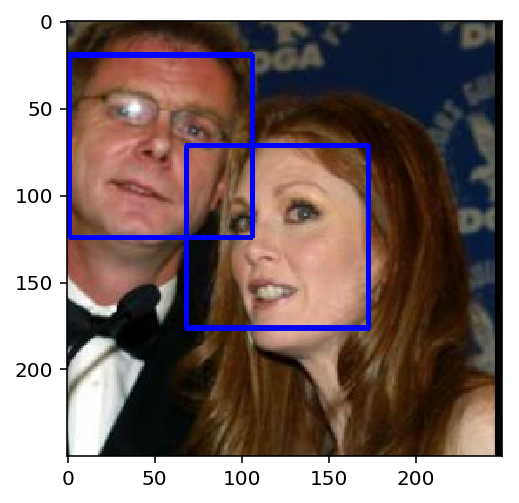

In [3]:
# Extract pre-trained face detector:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Load color (BGR) image:
img = cv2.imread(human_files[42])

# Convert BGR image to grayscale:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find faces in image:
faces = face_cascade.detectMultiScale(gray)

# Print number of faces detected in the image:
print("Number of faces detected:", len(faces))

# Get bounding box for each detected face:
for (x,y,w,h) in faces:
    # Add bounding box to color image:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting:
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box:
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# Return "True" if face is detected in image stored at img_path:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

We are going to use the code cell below to test the performance of the `face_detector` function, answering the two following questions:  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. Nevertheless, we will see that our algorithm falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
# Extract and store the first 100 images from each datasets:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# Work on the first 100 images from the human dataset:
ctr_human_dts = 0
for img_path in human_files_short:
    if face_detector(img_path):
        ctr_human_dts += 1

# Work on the first 100 images from the dog dataset:
ctr_dog_dts = 0
for img_path in dog_files_short:
    if face_detector(img_path):
        ctr_dog_dts += 1

# Print results:
print("{}% of the first 100 images in 'human_files' have a detected human face.".format(ctr_human_dts))
print("{}% of the first 100 images in 'dog_files' have a detected human face.".format(ctr_dog_dts))

98% of the first 100 images in 'human_files' have a detected human face.
17% of the first 100 images in 'dog_files' have a detected human face.


*Note Bene:* Here, we have used the face detector from OpenCV as a potential way to detect human images in our algorithm, but we could perfectly have chosen to explore other approaches (especially approaches that make use of deep learning).

<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [6]:
# Define VGG16 model:
VGG16 = models.vgg16(pretrained=True)

# Check if CUDA is available:
use_cuda = torch.cuda.is_available()

# Move model to GPU if CUDA is available:
if use_cuda:
    VGG16 = VGG16.cuda()
    
# Print VGG16 pretrained model:
print(VGG16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 88298437.47it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image (such as `'/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model. The output should always be an integer between 0 and 999, inclusive.

*Nota Bene:* Precisions about the appropriate way to pre-process tensors for pre-trained models can be found in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # Define VGG16 as global variable:
    global VGG16
    
    # Load the image:
    img_pil = Image.open(img_path).convert('RGB')
    
    # Define transforms:
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Preprocess and resize the image:
    img_tensor = preprocess(img_pil)[:3,:,:].unsqueeze(0)
    
    # Move tensor to CPU if CUDA available:
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # Put model in evaluation mode (default: training mode):
    VGG16 = VGG16.eval()
    
    # Apply model to tensor:
    img_output = VGG16.forward(img_tensor)
    
    # Determine predicted class:
    _, predicted = torch.max(img_output.data, 1)
    
    # NumPy doesn't support CUDA:
    if use_cuda:
        predicted = predicted.cpu()
        
    # Determine index to the predicted class:
    idx_predicted = int(np.squeeze(predicted.numpy()))
    
    return idx_predicted

We can now test our new function with the following image `'/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'`:

In [8]:
# Path to image to test:
test_img_path = '/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'

# Function predicted index:
test_idx_predicted = VGG16_predict(test_img_path)

# Print the result:
print("The function predicts index {} for image {}.".format(test_idx_predicted, test_img_path))

The function predicts index 252 for image /data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg.


If we refer to the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we can say that the label corresponding to the index `252` is `'affenpinscher, monkey pinscher, monkey dog'`.

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we can notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only to check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Below, we are going to use these elements in the `dog_detector` function, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
# Return "True" if dog is detected in image stored at img_path:
def dog_detector(img_path):
    img_pred = VGG16_predict(img_path)
    cnd_idx_dog = img_pred >= 151 and img_pred <= 268
    return cnd_idx_dog

### Assess the Dog Detector

We are going to use the code cell below to test the performance of the `dog_detector` function, answering the two following questions:  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

Ideally, we would like 0% of human images with a detected dog and 100% of dog images with a detected dog. Nevertheless, as for the `face_detector` function, we will see that our algorithm falls short of this goal, but still gives acceptable performance.

In [10]:
# Work on the first 100 images from the human dataset:
ctr_human_dts = 0
for img_path in human_files_short:
    if dog_detector(img_path):
        ctr_human_dts += 1

# Work on the first 100 images from the dog dataset:
ctr_dog_dts = 0
for img_path in dog_files_short:
    if dog_detector(img_path):
        ctr_dog_dts += 1

# Print results:
print("{}% of the first 100 images in 'human_files' have a detected dog.".format(ctr_human_dts))
print("{}% of the first 100 images in 'dog_files' have a detected dog.".format(ctr_dog_dts))

0% of the first 100 images in 'human_files' have a detected dog.
100% of the first 100 images in 'dog_files' have a detected dog.


*Nota Bene:* Here, we have used VGG-16 as a potential network to detect dog images in our algorithm, but we could perfectly have chosen other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).

<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, we will create a CNN that classifies dog breeds. Here, we are going to create our CNN _from scratch_ (so, we aren't going to use transfer learning _yet_!), and our objective is to attain a test accuracy of at least 10%. In Step 4 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/brittany.jpg"> | <img src="images/welsh_springer_spaniel.jpg">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/curly_coated_retriever.jpg"> | <img src="images/american_water_spaniel.jpg">


Likewise, recall that labradors come in yellow, chocolate, and black. Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | - | -
<img src="images/labrador_retriever_yellow.jpg"> | <img src="images/labrador_retriever_chocolate.jpg"> | <img src="images/labrador_retriever_black.jpg">

We also mention that random chance presents an exceptionally low bar: Setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

### Specify Data Loaders for the Dog Dataset

We are going to use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).

*Nota Bene:* [This documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) is a useful resource, and to augment our training and/or validation data, a wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform) can be used!

In [13]:
# Shortcut variables to the training, validation and testing datasets:
data_dir = '/data/dog_images'
training_dir = data_dir + '/train'
validation_dir = data_dir + '/valid'
testing_dir = data_dir + '/test'

# Transforms for the training, validation and testing datasets:

train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                      ])

validate_test_transforms = transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])
                                              ])

# Load the training, validation and testing datasets with ImageFolder:
training_dataset = datasets.ImageFolder(training_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validate_test_transforms)
testing_dataset = datasets.ImageFolder(testing_dir, transform=validate_test_transforms)

# Using the image datasets and the trainforms, define the dataloaders:
trainingloader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64)
testingloader = torch.utils.data.DataLoader(testing_dataset, batch_size=64)

# Gather all dataloaders into one dictionary:
loaders_scratch = {
    'train': trainingloader,
    'valid': validationloader,
    'test': testingloader
}

Above, for the training, we have applied a serie of transformations (random cropping, horizontal flipping and rotation) which has augmented the dataset and will help the network generalize leading to better performance. We have also made sure the input data is resized to 224x224 pixels (224x224 pixels are required by the pre-trained networks, and to be consistent with all the work done in this notebook, we use these dimensions as well here).

The validation and testing datasets are used to measure the model's performance on data it hasn't seen yet. For this we don't want to apply any transformation, but we need to resize and then crop the images to the appropriate size.

*Nota Bene:* For all three datasets, we have equally normalized the means and standard deviations of the image, first, to facilitate the training process, and second, to be consistent with all the work done in this notebook, because the pre-trained networks we use have been trained on the ImageNet dataset (in this dataset, each color channel is normalized separately).

### Model Architecture

Below, we are going to create a CNN to classify dog breed.

In [13]:
# Class defining the architecture of the scratch model:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer 1:
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        # Convolutional layer 2:
        self.conv2 = nn.Conv2d(6, 9, 3, padding=1)
        # Convolutional layer 3:
        self.conv3 = nn.Conv2d(9, 12, 3, padding=1)
        # Max pooling layer:
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layer 1:
        self.fc1 = nn.Linear(12*28*28, 12*28*14)
        # Linear layer 2:
        self.fc2 = nn.Linear(12*28*14, 133)
        # Dropout layer (p=0.2):
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        # Size changes from (3, 224, 224) to (6, 112, 112):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # Size changes from (6, 112, 112) to (9, 56, 56)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # Size changes from (9, 56, 56) to (12, 28, 28)
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # Flatten image input:
        x = x.view(-1, self.num_flat_features(x))
        # Add dropout layer:
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function:
        x = nn.functional.relu(self.fc1(x))
        # Add dropout layer:
        x = self.dropout(x)
        # Add 2nd hidden layer, with relu activation function:
        x = self.fc2(x)
        # Return result:
        return x
    
    def num_flat_features(self, x):
        # All dimensions except the batch dimension:
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Instantiate the CNN:
model_scratch = Net()

# Move model to GPU if CUDA is available:
if use_cuda:
    model_scratch.cuda()

# Print our instantiated CNN:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9408, out_features=4704, bias=True)
  (fc2): Linear(in_features=4704, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
)


Above, we have constructed a simple convolutional neural network.

The structure of this neural network, which can be visualized reading the forward pass, is composed, first, of three convolutional layers (stack of filtered images) associated with classical ReLU activation functions and maxpooling layers (reduction of the length and of the width of the image, augmentation of its depth, tracking the in-depth patterns of the picture).

The more convolutional layers we include in the neural network architecture, the more complex patters in color and shape our model will be able to catch: Here, clearly, our objective is not to build a performant neural network to tackle our problem, doing it from scratch is not a good idea, nevertheless, we want to illustrate the learning power of convolutional neural networks to challenge classification problems.

Finally, we have added two hidden fully connected linear layers, with dropout layers to facilitate the training of our model and avoid overfitting.

We can equally say that our first layer has input shape of (3, 224, 224), corresponding of the initial shape of our images, and that our last layer produces a 133 dimensions output, for the 133 dog breeds categories defined by our problem.

### Specify Loss Function and Optimizer

We are going to use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html), and to save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch`.

In [14]:
# Define loss function (categorical cross-entropy):
criterion_scratch = nn.CrossEntropyLoss()

# Define optimizer (stochastic gradient descent):
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

### Train and Validate the Model

Now, we are going to train and validate our model in the code cells below: During this process, we are going to [save the best model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'models/model_scratch.pth'`, and track the registered performances at filepath `'trainings/perf_scratch.txt'`

In [12]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, perf_path):
    """Return trained model"""
    
    # Track the training session:
    print("Training of the neural network:\n")
    start_time = time.time()
    
    # Create a performance tracking file for the training session:
    perf_file = open(perf_path, 'w')
    perf_file.write("# Epoch, Training Loss, Training Accuracy, Validation Loss, Validation Accuracy\n")
    perf_file.close()
    
    # Initialize tracker for minimum validation loss:
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        print("*** Epoch {}".format(epoch))
        
        # Put model in training mode:
        model.train()
        
        # Train the model:
        # Part 1:
        # Initialize variable to monitor training loss:
        train_loss = 0.
        # Training run:
        for data in loaders['train']:
            inputs, labels = data
            # Move to GPU if CUDA is available:
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # Clear the gradients of all optimized variables:
            optimizer.zero_grad()
            # Forward pass (compute predicted outputs by passing inputs to the model):
            outputs = model.forward(inputs)
            # Calculate the batch loss:
            loss = criterion(outputs, labels)
            # Backward pass (compute gradient of the loss with respect to model parameters):
            loss.backward()
            # Perform a single optimization step (parameter update):
            optimizer.step()
            # Update training loss:
            train_loss += loss.item()*inputs.size(0)
            
        # Put model in evaluation mode:
        model.eval()
        
        # Train the model:
        # Part 2:
        # Initialize variable to monitor training loss and accuracy:
        train_loss = 0.
        correct = 0
        total = 0
        # Training run:
        with torch.no_grad():
            for data in loaders['train']:
                inputs, labels = data
                # Move to GPU if CUDA is available:
                if use_cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()
                # Forward pass (compute predicted outputs by passing inputs to the model):
                outputs = model.forward(inputs)
                # Calculate the batch loss:
                loss = criterion(outputs, labels)
                # Update training loss:
                train_loss += loss.item()*inputs.size(0)
                # Update accuracy:
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Calculate average losses and accuracy:
        train_loss /= len(loaders['train'].dataset)
        train_acc = 100.*correct/total
        # Print and register the results:
        print("Training: Loss... {:.6f},".format(train_loss),
              "Accuracy... {:.2f}%".format(train_acc))
        perf_file = open(perf_path, 'a')
        perf_file.write("{} {:.2f} {:.2f}".format(epoch, train_loss, train_acc))
        
        # Validate the model:
        # Initialize variable to monitor validation loss and accuracy:
        valid_loss = 0.
        correct = 0
        total = 0
        # Validation run:
        with torch.no_grad():
            for data in loaders['valid']:
                inputs, labels = data
                # Move to GPU if CUDA is available:
                if use_cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()
                # Forward pass (compute predicted outputs by passing inputs to the model):
                outputs = model.forward(inputs)
                # Calculate the batch loss:
                loss = criterion(outputs, labels)
                # Update training loss:
                valid_loss += loss.item()*inputs.size(0)
                # Update accuracy:
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Calculate average losses and accuracy:
        valid_loss /= len(loaders['valid'].dataset)
        valid_acc = 100.*correct/total
        # Print and register the results:
        print("Validation: Loss... {:.6f},".format(valid_loss),
              "Accuracy... {:.2f}%".format(valid_acc))
        perf_file.write(" {:.2f} {:.2f}\n".format(valid_loss, valid_acc))
        perf_file.close()
        
        # Save the model if validation loss has decreased:
        if valid_loss < valid_loss_min:
            print("=> Validation loss decreased ({:.6f} --> {:.6f}), saving model...".format(
                valid_loss_min,
                valid_loss
            ))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # Time performance:
    end_time = time.time()
    total_time = int(end_time - start_time)
    hours = total_time // 3600
    minutes = (total_time % 3600) // 60
    seconds = (total_time % 3600) % 60
    print("\nEnd of the tests... {:02d}h {:02d}m {:02d}s".format(hours, minutes, seconds))
            
    # Return final trained model (not necessarily the best):
    return model

In [13]:
# Create folders 'models' and 'trainings':
os.mkdir('models')
os.mkdir('trainings')

In [17]:
# Train the model:
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'models/model_scratch.pth',
                      'trainings/perf_scratch.txt')

Training of the neural network:

*** Epoch 1
Training: Loss... 4.848765, Accuracy... 1.11%
Validation: Loss... 4.853134, Accuracy... 0.96%
=> Validation loss decreased (inf --> 4.853134), saving model...
*** Epoch 2
Training: Loss... 4.729821, Accuracy... 2.29%
Validation: Loss... 4.706814, Accuracy... 3.11%
=> Validation loss decreased (4.853134 --> 4.706814), saving model...
*** Epoch 3
Training: Loss... 4.656105, Accuracy... 3.11%
Validation: Loss... 4.629260, Accuracy... 2.51%
=> Validation loss decreased (4.706814 --> 4.629260), saving model...
*** Epoch 4
Training: Loss... 4.620441, Accuracy... 3.13%
Validation: Loss... 4.587282, Accuracy... 3.71%
=> Validation loss decreased (4.629260 --> 4.587282), saving model...
*** Epoch 5
Training: Loss... 4.526120, Accuracy... 4.12%
Validation: Loss... 4.457369, Accuracy... 5.27%
=> Validation loss decreased (4.587282 --> 4.457369), saving model...
*** Epoch 6
Training: Loss... 4.472838, Accuracy... 4.37%
Validation: Loss... 4.427135, Accu

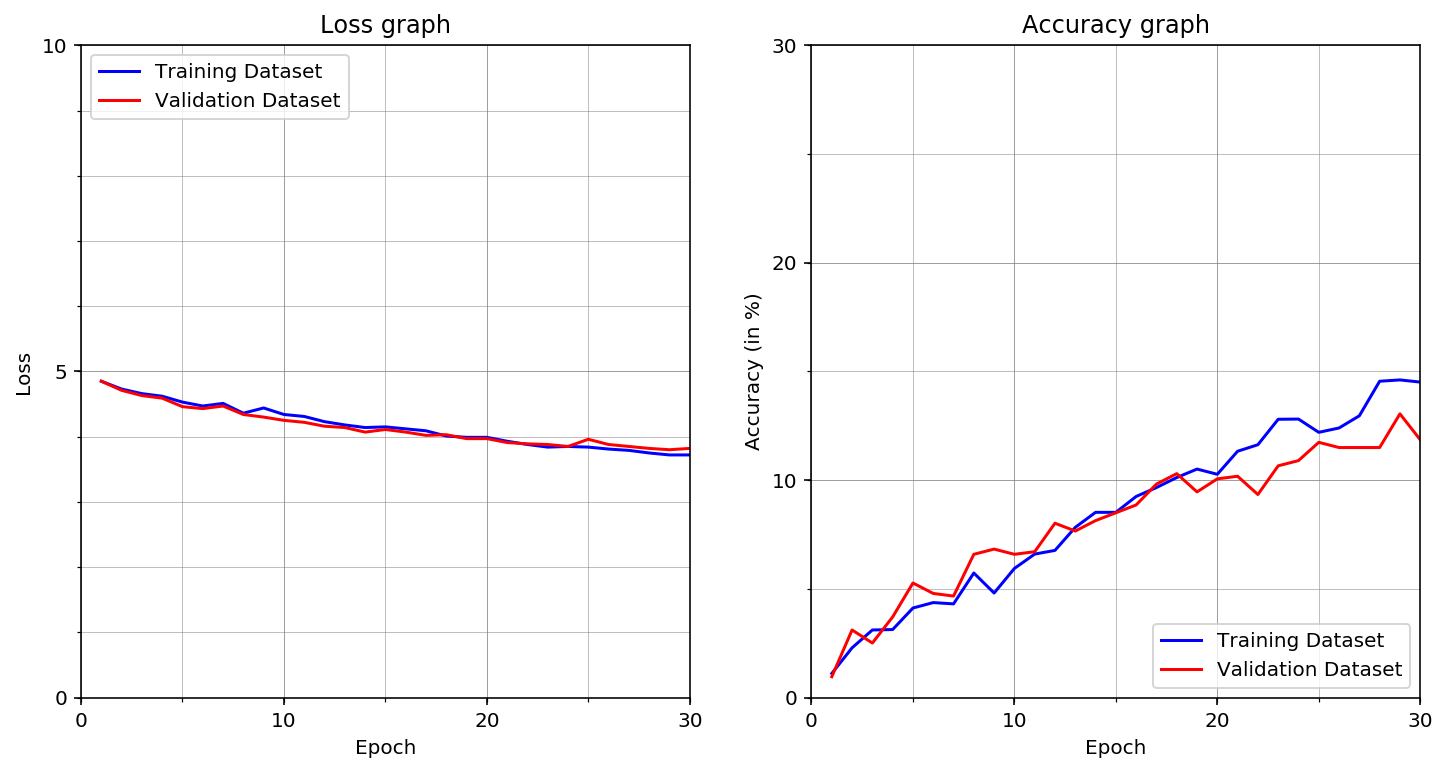

In [19]:
# Read the data contained in the performance file:

epoch_list = []
training_loss_list = []
training_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

with open('trainings/perf_scratch.txt', 'r') as performance_file:
    f_line = performance_file.readline()
    while f_line != "":
        if f_line[0] != "#":
            f_line_l = f_line.strip().split()
            epoch_list.append(int(f_line_l[0]))
            training_loss_list.append(float(f_line_l[1]))
            training_accuracy_list.append(float(f_line_l[2]))
            validation_loss_list.append(float(f_line_l[3]))
            validation_accuracy_list.append(float(f_line_l[4]))
        f_line = performance_file.readline()

# Represent the loss and accuracy graphs obtained during the training:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Configuration of the loss graph:
axes[0].set_title('Loss graph')
axes[0].plot(epoch_list, training_loss_list, color='blue', linestyle='solid', label='Training Dataset')
axes[0].plot(epoch_list, validation_loss_list, color='red', linestyle='solid', label='Validation Dataset')
axes[0].set_xlim(0, 30)
axes[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(3))
axes[0].xaxis.set_minor_locator(mpl.ticker.MaxNLocator(6))
axes[0].set_xlabel('Epoch')
axes[0].set_ylim(0, 10)
axes[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(2))
axes[0].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
axes[0].set_ylabel('Loss')
axes[0].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[0].legend(loc=2)

# Configuration of the accuracy graph:
axes[1].set_title('Accuracy graph')
axes[1].plot(epoch_list, training_accuracy_list, color='blue', linestyle='solid', label='Training Dataset')
axes[1].plot(epoch_list, validation_accuracy_list, color='red', linestyle='solid', label='Validation Dataset')
axes[1].set_xlim(0, 30)
axes[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(3))
axes[1].xaxis.set_minor_locator(mpl.ticker.MaxNLocator(6))
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0, 30)
axes[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(3))
axes[1].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(6))
axes[1].set_ylabel('Accuracy (in %)')
axes[1].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[1].legend(loc=4)

# Save the training graphs:
fig.savefig('trainings/graphs_scratch.png')

During this training, the best performances have been obtained at epoch 29, with an average validation loss of 3.795109 and an accuracy of 13.05%.

Although the problem is difficult to tackle, these are not great performances.

Nevertheless, as it has been said, our objective, by building a very simple convolutional neural network from scratch, is only to illustrate the learning power of convolutional neural networks to challenge classification problems.

### Test the Model

Now, we are going to try out our model on the test dataset of dog images.

Our objective is very modest: Ensure that our test accuracy is greater than 10%.

In [20]:
# Load the model that got the best validation accuracy:
model_scratch.load_state_dict(torch.load('models/model_scratch.pth'))

In [21]:
def test(loaders, model, criterion, use_cuda):

    # Monitor test loss and accuracy:
    test_loss = 0.
    correct = 0
    total = 0
    
    # Pass on the test dataset:
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # Move to GPU if available:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model:
        output = model(data)
        # Calculate the loss:
        loss = criterion(output, target)
        # Update average test loss: 
        test_loss = test_loss + ((1/(batch_idx + 1))*(loss.data - test_loss))
        # Convert output probabilities to predicted class:
        pred = output.data.max(1, keepdim=True)[1]
        # Compare predictions to true label:
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    # Print the results:
    print("Test of our best model on the test dataset:")
    print("Loss... {:.6f},".format(test_loss),
          "Accuracy... {:.2f}%".format(100.*correct/total))
    print("On the test dataset, {} images over {} have been correctly classified".format(int(correct), int(total)))

In [24]:
# Call Test function:    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test of our best model on the test dataset:
Loss... 3.884303, Accuracy... 10.41%
On the test dataset, 87 images over 836 have been correctly classified


Well, we have achieved our (modest) objective!

<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images: Here, our CNN must attain at least 60% accuracy on the test dataset.

### Specify Data Loaders for the Dog Dataset

Like it has been done previously, we are going to use three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images. 

The same data loaders from the previous step, when we created a CNN from scratch, are going to be used for this step.

In [14]:
# Specify data loaders:
loaders_transfer = loaders_scratch

### Model Architecture

Now, we are going to use transfer learning to create a CNN to classify dog breed. In the code cell below, we will save our initialized model as the variable `model_transfer`.

In [15]:
# Choose a pretrained neural network:
model_transfer = models.densenet161(pretrained=True)

# Freeze the features but adapt the classifier:

for param in model_transfer.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([('input', nn.Linear(2208, 1054)),
                                        ('drop1', nn.Dropout(p=0.2)),
                                        ('act1', nn.ReLU()),
                                        ('hl', nn.Linear(1054, 266)),
                                        ('drop2', nn.Dropout(p=0.2)),
                                        ('act2', nn.ReLU()),
                                        ('output', nn.Linear(266, 133))]))

model_transfer.classifier = classifier

# Move model to GPU if CUDA is available:
if use_cuda:
    model_transfer = model_transfer.cuda()
    
# Print our built model:
print(model_transfer)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:01<00:00, 65380021.93it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

For this task, we are going to use a [pre-trained](https://pytorch.org/docs/master/torchvision/models.html) neural network, more precisely a DenseNet-161 model.

For that, we froze all the features, and only adapated the classifier part to match our purpose to classify dog breeds into one of the possible 133 categories.

We did this because using pre-trained neural networks is in most cases a good idea to solve computer vision classification problems. In particular, here, the pre-trained neural network we are going to use has been trained on the ImageNet dataset, which includes 118 dog breed categories over its 1000 classification categories: It is the reason why we have frozen all the features and decided to adapt and train only its classifier part.

About the classifier part, it can be noticed that the different hyperparameters (number of hidden layers, number of hidden units, activation functions, dropout probabilities...) have been fixed: In order to leave this notebook clear, I prefer to do not show the different tests that have led me to make these choices.

### Specify Loss Function and Optimizer

To be consistent with the work we have done when we built previously a CNN from scratch, we are going to use the same loss function and optimizer.

We are going to save them below as `criterion_transfer` and `optimizer_transfer`.

In [16]:
# Define loss function (categorical cross-entropy):
criterion_transfer = nn.CrossEntropyLoss()

# Define optimizer (stochastic gradient descent):
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01, momentum=0.9)

### Train and Validate the Model

Now, we are going to train and validate our model in the code cells below: During this process, we are going to [save the best model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'models/model_transfer.pth'`, and track the registered performances at filepath `'trainings/perf_transfer.txt'`.

In [17]:
# Train the model:
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer,
                       criterion_transfer, use_cuda, 'models/model_transfer.pth',
                       'trainings/perf_transfer.txt')

Training of the neural network:

*** Epoch 1
Training: Loss... 4.419073, Accuracy... 16.69%
Validation: Loss... 4.408728, Accuracy... 15.81%
=> Validation loss decreased (inf --> 4.408728), saving model...
*** Epoch 2
Training: Loss... 2.105065, Accuracy... 47.41%
Validation: Loss... 1.880878, Accuracy... 54.61%
=> Validation loss decreased (4.408728 --> 1.880878), saving model...
*** Epoch 3
Training: Loss... 1.372139, Accuracy... 62.78%
Validation: Loss... 1.015682, Accuracy... 71.98%
=> Validation loss decreased (1.880878 --> 1.015682), saving model...
*** Epoch 4
Training: Loss... 1.114357, Accuracy... 69.16%
Validation: Loss... 0.772110, Accuracy... 78.20%
=> Validation loss decreased (1.015682 --> 0.772110), saving model...
*** Epoch 5
Training: Loss... 1.057284, Accuracy... 70.28%
Validation: Loss... 0.667240, Accuracy... 80.36%
=> Validation loss decreased (0.772110 --> 0.667240), saving model...
*** Epoch 6
Training: Loss... 0.965303, Accuracy... 72.75%
Validation: Loss... 0.6

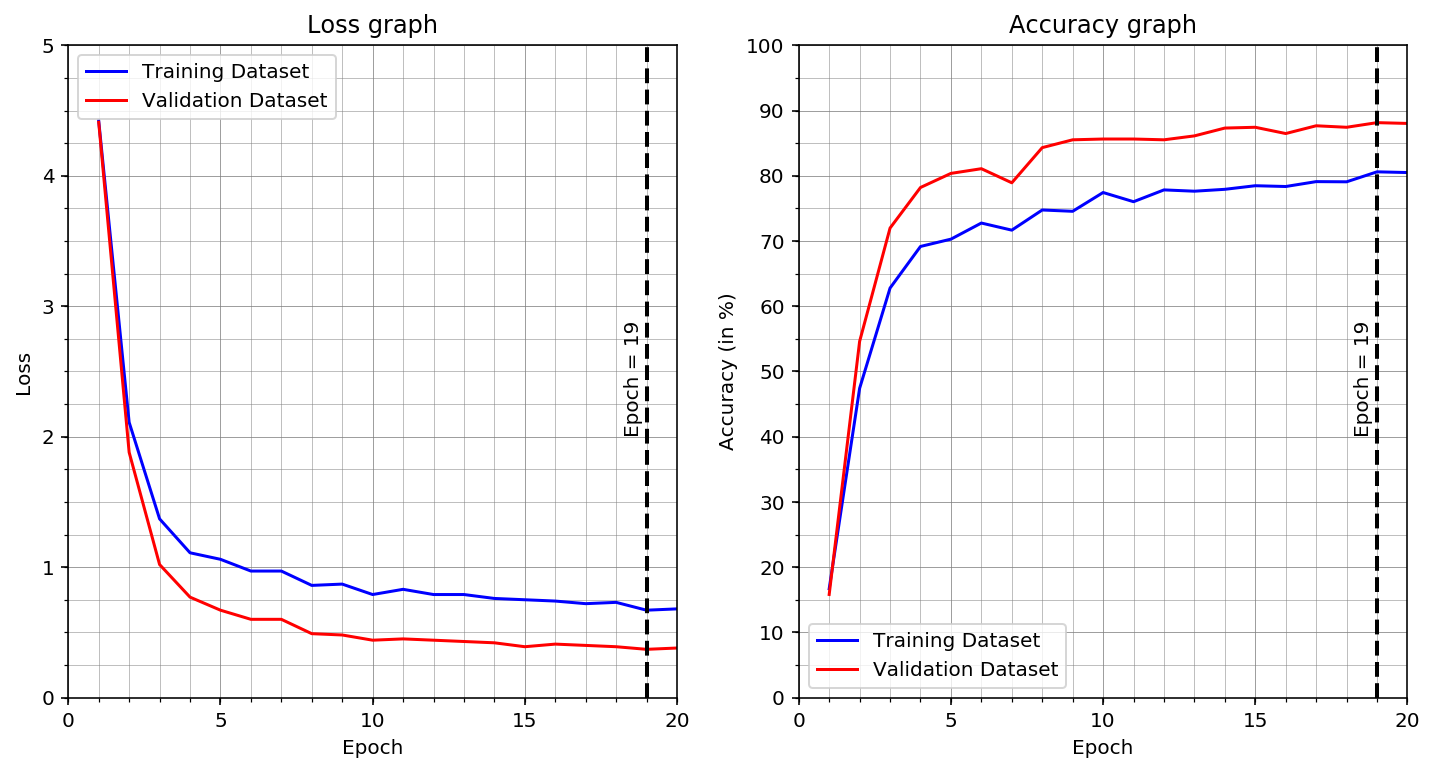

In [18]:
# Read the data contained in the performance file:

epoch_list = []
training_loss_list = []
training_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

with open('trainings/perf_transfer.txt', 'r') as performance_file:
    f_line = performance_file.readline()
    while f_line != "":
        if f_line[0] != "#":
            f_line_l = f_line.strip().split()
            epoch_list.append(int(f_line_l[0]))
            training_loss_list.append(float(f_line_l[1]))
            training_accuracy_list.append(float(f_line_l[2]))
            validation_loss_list.append(float(f_line_l[3]))
            validation_accuracy_list.append(float(f_line_l[4]))
        f_line = performance_file.readline()

# Represent the loss and accuracy graphs obtained during the training:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Configuration of the loss graph:
axes[0].set_title('Loss graph')
axes[0].plot(epoch_list, training_loss_list, color='blue', linestyle='solid', label='Training Dataset')
axes[0].plot(epoch_list, validation_loss_list, color='red', linestyle='solid', label='Validation Dataset')
axes[0].plot([19, 19], [0, 5], color='black', linestyle='dashed', linewidth=2)
axes[0].set_xlim(0, 20)
axes[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
axes[0].xaxis.set_minor_locator(mpl.ticker.MaxNLocator(20))
axes[0].set_xlabel('Epoch')
axes[0].set_ylim(0, 5)
axes[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
axes[0].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(20))
axes[0].set_ylabel('Loss')
axes[0].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[0].text(18.75, 2, 'Epoch = 19', rotation=90, rotation_mode='anchor')
axes[0].legend(loc=2)

# Configuration of the accuracy graph:
axes[1].set_title('Accuracy graph')
axes[1].plot(epoch_list, training_accuracy_list, color='blue', linestyle='solid', label='Training Dataset')
axes[1].plot(epoch_list, validation_accuracy_list, color='red', linestyle='solid', label='Validation Dataset')
axes[1].plot([19, 19], [0, 100], color='black', linestyle='dashed', linewidth=2)
axes[1].set_xlim(0, 20)
axes[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
axes[1].xaxis.set_minor_locator(mpl.ticker.MaxNLocator(20))
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
axes[1].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(21))
axes[1].set_ylabel('Accuracy (in %)')
axes[1].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[1].text(18.75, 40, 'Epoch = 19', rotation=90, rotation_mode='anchor')
axes[1].legend(loc=3)

# Save the training graphs:
fig.savefig('trainings/graphs_transfer.png')

During this training, the best performances have been obtained at epoch 19, with an average validation loss of 0.365228 and an accuracy of 88.14%.

### Test the Model

Now, we are going to try out our model on the test dataset of dog images.
Here, our objective is to ensure that our test accuracy is greater than 60%.

In [19]:
# Load the model that got the best validation accuracy:
model_transfer.load_state_dict(torch.load('models/model_transfer.pth'))

In [22]:
# Call Test function:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test of our best model on the test dataset:
Loss... 0.404696, Accuracy... 87.32%
On the test dataset, 730 images over 836 have been correctly classified


Well done! We have achieved our objective!

### Predict Dog Breed with the Model

In this section, we are going to write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by our model.  

In [14]:
# List of class names by index:
class_names = [item[4:].replace("_", " ") for item in training_dataset.classes]

# Function that predicts dog breed from image:
def predict_breed_transfer(img_path):
    """Return dog breed prediction from image"""
    
    # Load the image:
    img_pil = Image.open(img_path).convert('RGB')
    
    # Define transforms:
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Preprocess and resize the image:
    img_tensor = preprocess(img_pil)[:3,:,:].unsqueeze(0)
    
    # Move tensor to CPU if CUDA available:
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # Apply model to tensor:
    img_output = model_transfer(img_tensor)
    
    # Determine predicted class:
    _, predicted = torch.max(img_output.data, 1)
    
    # NumPy doesn't support CUDA:
    if use_cuda:
        predicted = predicted.cpu()
        
    # Determine index to the predicted class:
    idx_predicted = int(np.squeeze(predicted.numpy()))
    
    # Determine label to the predicted class:
    label_predicted = class_names[idx_predicted]
    
    return label_predicted

Now, we can perform some tests based on previous exposed dog images. 

In [24]:
# Test 1:
label_predicted = predict_breed_transfer('images/american_water_spaniel.jpg')
print("Our model's prediction for this American Water Spaniel is {}.".format(label_predicted))

Our model's prediction for this American Water Spaniel is American water spaniel.


In [25]:
# Test 2:
label_predicted = predict_breed_transfer('images/labrador_retriever_yellow.jpg')
print("Our model's prediction for this Yellow Labrador Retriever is {}.".format(label_predicted))

Our model's prediction for this Yellow Labrador Retriever is Labrador retriever.


In [26]:
# Test 3:
label_predicted = predict_breed_transfer('images/welsh_springer_spaniel.jpg')
print("Our model's prediction for this Welsh Springer Spaniel is {}.".format(label_predicted))

Our model's prediction for this Welsh Springer Spaniel is Irish red and white setter.


As it can be seen, our first two predictions are OK, meanwhile the last one is KO.

<a id='step5'></a>
## Step 5: Write our Algorithm

Finally, we are going to write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.

Then,
- if a __dog__ is detected in the image, the algorithm returns the predicted breed.
- if a __human__ is detected in the image, the algorithm returns the resembling dog breed.
- if __neither__ is detected in the image, the algorithms provides output that indicates an error.

![Sample Human Output](images/sample_human_output.png)

In [18]:
# Function that displays image from path:
def display_image(img_path):
    """Display image from path"""
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

In [19]:
# Final prediction app:

def run_app(img_path):
    """Display image and predicted dog breed"""
    
    # Dog test:
    if dog_detector(img_path):
        print("Hello, dog!")
        display_image(img_path)
        predicted_dog_breed = predict_breed_transfer(img_path)
        print("Your predicted breed is... {}".format(predicted_dog_breed))
    
    # Human face test:
    elif face_detector(img_path):
        print("Hello, human!")
        display_image(img_path)
        predicted_dog_breed = predict_breed_transfer(img_path)
        print("You look like a... {}".format(predicted_dog_breed))
        
    # No human nor dog:
    else:
        print("Hello, no human nor dog has been detected in the image!")
        display_image(img_path)
    
    # End of the app:
    print("Goodbye!")

<a id='step6'></a>
## Step 6: Test our Algorithm

In this section, we will take our new algorithm for a spin!

To make this work further, to go a step ahead, here are some possible points of improvement of our algorithm:
* Increase the volumetry of the training and validation datasets.
* Fine tune the hyperparameters of our model (number of hidden layers, number of hidden units, activation functions, dropout probabilities...).
* Try other optimizers.

Equally, it can be a good idea to deploy our algorithm as an API thanks to Flask library and, for example, AWS!

Hello, human!


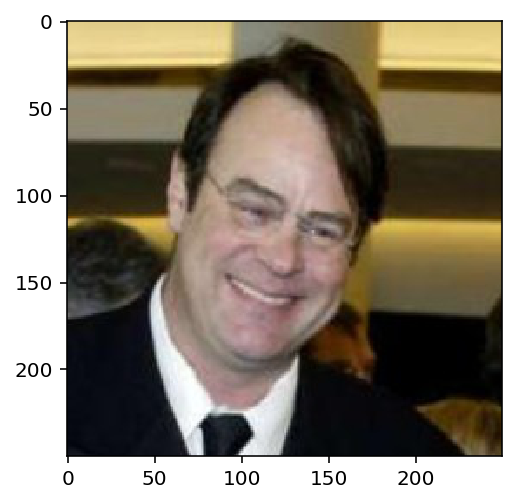

You look like a... Bull terrier
Goodbye!



Hello, human!


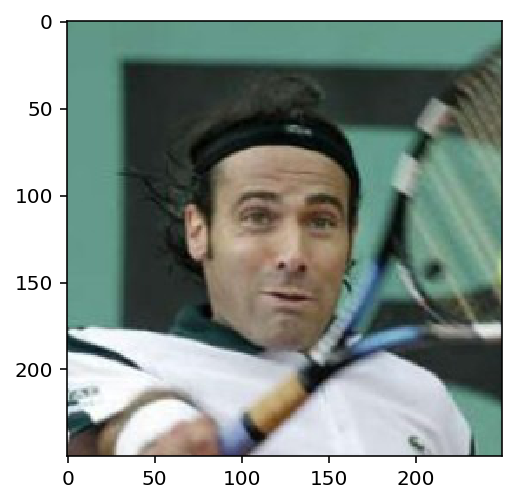

You look like a... Brittany
Goodbye!



Hello, human!


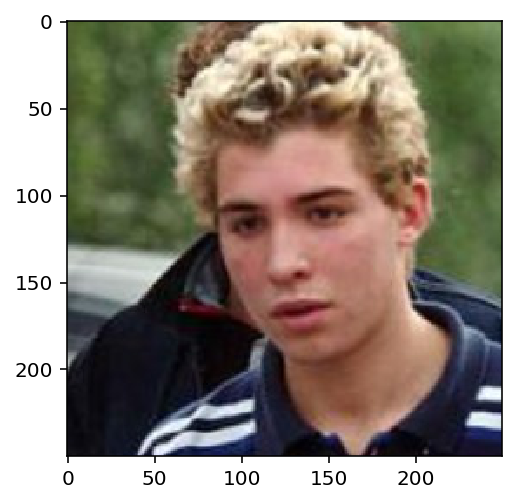

You look like a... Komondor
Goodbye!



Hello, dog!


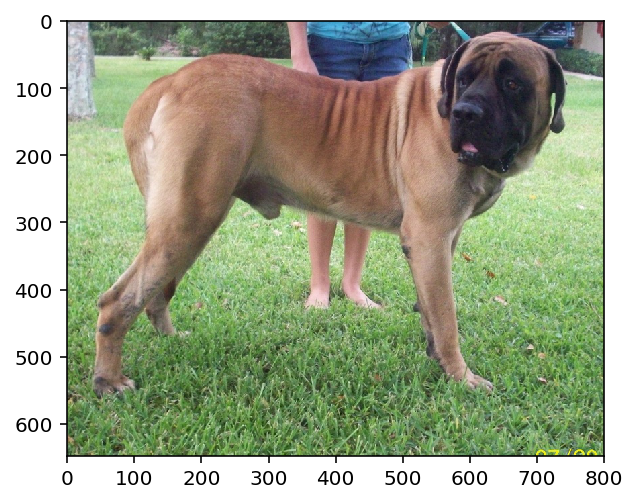

Your predicted breed is... Mastiff
Goodbye!



Hello, dog!


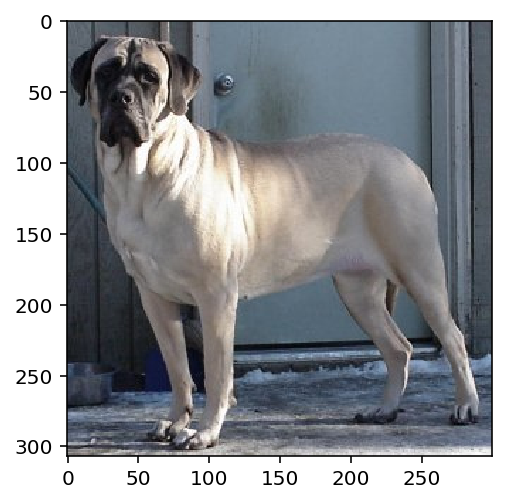

Your predicted breed is... Mastiff
Goodbye!



Hello, dog!


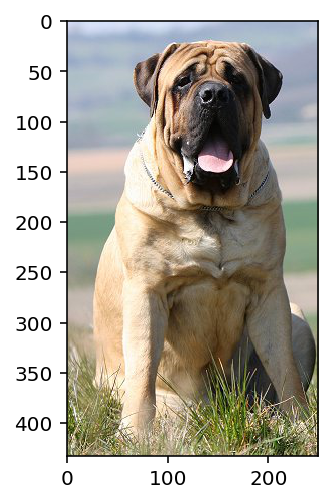

Your predicted breed is... Bullmastiff
Goodbye!





In [29]:
# Test on humans and dogs:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)
    print("\n\n")

Hello, no human nor dog has been detected in the image!


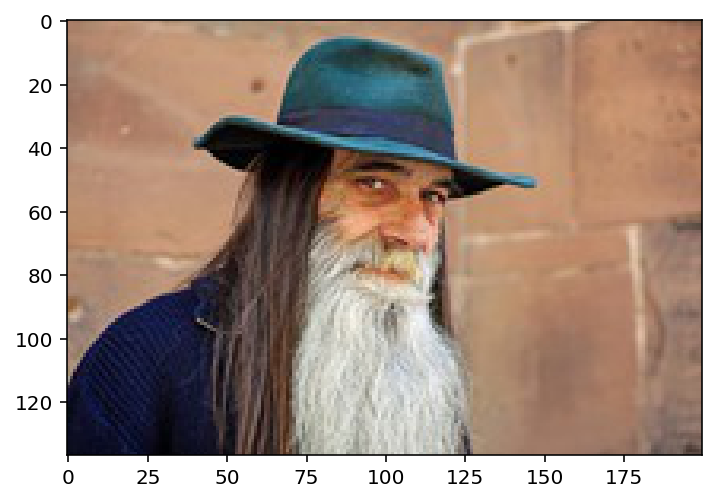

Goodbye!


In [21]:
# Test on an old man, with a wizard style:
run_app('images/old_man.jpg')

It seems that this "wizard" has bewitched our classifier!

Hello, human!


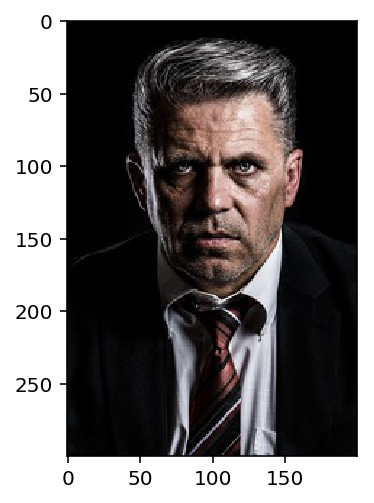

You look like a... Bull terrier
Goodbye!


In [22]:
# Test on a lawyer:
run_app('images/lawyer.jpg')

Our classifier did a good job here!

Hello, dog!


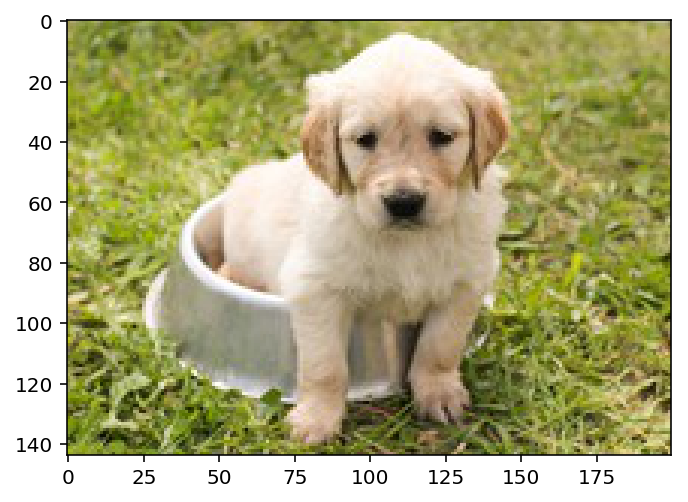

Your predicted breed is... Golden retriever
Goodbye!


In [23]:
# Test on a Golden Retriever:
run_app('images/golden_retriever.jpg')

Good job!

Hello, dog!


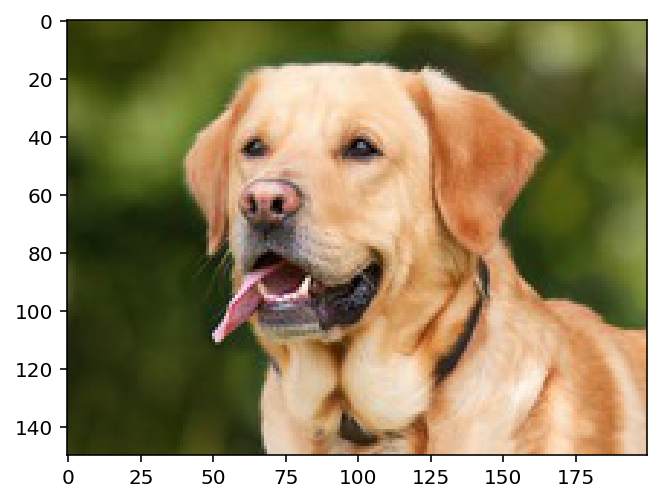

Your predicted breed is... Labrador retriever
Goodbye!


In [25]:
# Test on a Labrador:
run_app('images/labrador.jpg')

Yes!

Hello, no human nor dog has been detected in the image!


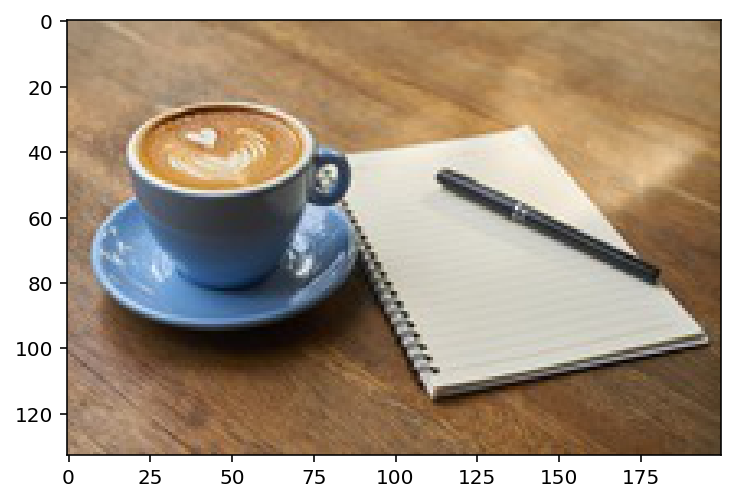

Goodbye!


In [27]:
# Test on a coffee cup:
run_app('images/coffee.jpg')

This conclusion is the one which was expected!

Hello, no human nor dog has been detected in the image!


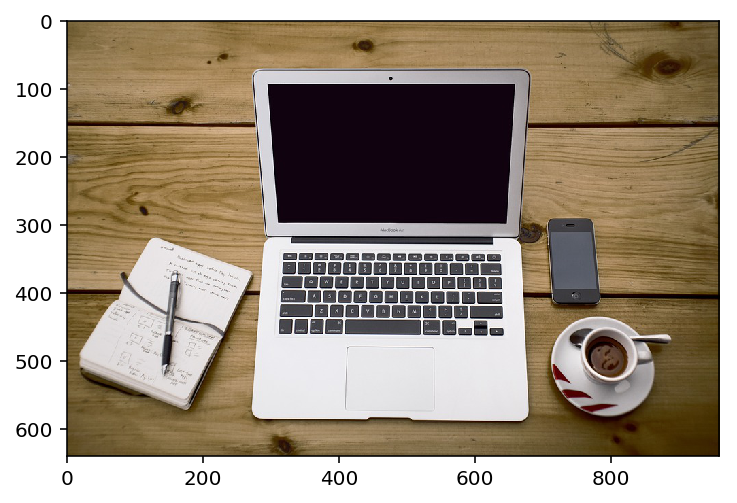

Goodbye!


In [28]:
# Test on a personal laptop:
run_app('images/personal_laptop.jpg')

Good prediction too!